In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(gridExtra)
library(ggplot2)
library(RColorBrewer)
library(dichromat)
library(viridis)
library(ggmap)
library(maps)
library(maptools)
library(sp)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: viridisLite
Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.
Loading required package: sp
Checking rgeos availability: TRUE


In [2]:
data = read.csv("Final_dataset.csv",header=TRUE,sep=",")
head(data)

country,country_code,continent,continent_code,year,sex,age,suicides_no,population,suicides.100k.pop,country.year,HDI.for.year,gdp_for_year....,gdp_per_capita....,generation,latitude,longitude
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<dbl>,<dbl>
Albania,ALB,Europe,EUR,1987,male,15-24 years,21,312900,6.71,Albania1987,NA,"2,156,624,900",796,Generation X,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,male,35-54 years,16,308000,5.19,Albania1987,NA,"2,156,624,900",796,Silent,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,female,15-24 years,14,289700,4.83,Albania1987,NA,"2,156,624,900",796,Generation X,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,male,75+ years,1,21800,4.59,Albania1987,NA,"2,156,624,900",796,G.I. Generation,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,male,25-34 years,9,274300,3.28,Albania1987,NA,"2,156,624,900",796,Boomers,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,female,75+ years,1,35600,2.81,Albania1987,NA,"2,156,624,900",796,G.I. Generation,41.15333,20.16833


In [3]:
#Data cleaning
suicide_data <- data %>%
  select(-c('HDI.for.year', 'suicides.100k.pop')) %>%
  rename(gdp_for_year = 'gdp_for_year....', 
         gdp_per_capita = 'gdp_per_capita....', 
         country_year = 'country.year') %>%
  as.data.frame()
head(suicide_data)

country,country_code,continent,continent_code,year,sex,age,suicides_no,population,country_year,gdp_for_year,gdp_per_capita,generation,latitude,longitude
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<dbl>
Albania,ALB,Europe,EUR,1987,male,15-24 years,21,312900,Albania1987,"2,156,624,900",796,Generation X,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,male,35-54 years,16,308000,Albania1987,"2,156,624,900",796,Silent,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,female,15-24 years,14,289700,Albania1987,"2,156,624,900",796,Generation X,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,male,75+ years,1,21800,Albania1987,"2,156,624,900",796,G.I. Generation,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,male,25-34 years,9,274300,Albania1987,"2,156,624,900",796,Boomers,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,female,75+ years,1,35600,Albania1987,"2,156,624,900",796,G.I. Generation,41.15333,20.16833


In [4]:
suicide_data <- suicide_data %>%
  filter(year != 2016) %>% 
  select(-country_year)

minimum_years <- suicide_data %>%
  group_by(country) %>%
  summarize(rows = n(), 
            years = rows / 12) %>%
  arrange(years)

suicide_data <- suicide_data %>%
  filter(!(country %in% head(minimum_years$country, 7)))

In [5]:
suicide_data$age <- gsub(" years", "", suicide_data$age)
suicide_data$sex <- ifelse(suicide_data$sex == "male", "Male", "Female")


In [6]:
install.packages('countrycode')
library(countrycode)

suicide_data$continent <- countrycode(sourcevar = suicide_data[, "country"],
                              origin = "country.name",
                              destination = "continent")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [7]:
data_nominal <- c('country', 'sex', 'continent')
suicide_data[data_nominal] <- lapply(suicide_data[data_nominal], function(x){factor(x)})


In [8]:
suicide_data$age <- factor(suicide_data$age, 
                   ordered = T, 
                   levels = c("5-14",
                              "15-24", 
                              "25-34", 
                              "35-54", 
                              "55-74", 
                              "75+"))

In [9]:
suicide_data$generation <- factor(suicide_data$generation, 
                   ordered = T, 
                   levels = c("G.I. Generation", 
                              "Silent",
                              "Boomers", 
                              "Generation X", 
                              "Millenials", 
                              "Generation Z"))


In [10]:
suicide_data <- as_tibble(suicide_data)

In [11]:
global_average <- (sum(as.numeric(suicide_data$suicides_no)) / sum(as.numeric(suicide_data$population))) * 100000

In [12]:
summary(suicide_data)
head(suicide_data)

      country       country_code      continent     continent_code
 Argentina:  372   ARG    :  372   Africa  :  828   AFR :  828    
 Austria  :  372   AUT    :  372   Americas: 9156   AMR : 9156    
 Belgium  :  372   BEL    :  372   Asia    : 5268   EMR :  792    
 Brazil   :  372   BRA    :  372   Europe  :11268   EUR :13872    
 Chile    :  372   CHL    :  372   Oceania :  972   SEAR:  576    
 Colombia :  372   COL    :  372                    WPR : 2268    
 (Other)  :25260   (Other):25260                                  
      year          sex           age        suicides_no     
 Min.   :1985   Female:13746   5-14 :4582   Min.   :    0.0  
 1st Qu.:1995   Male  :13746   15-24:4582   1st Qu.:    3.0  
 Median :2002                  25-34:4582   Median :   25.0  
 Mean   :2001                  35-54:4582   Mean   :  244.9  
 3rd Qu.:2008                  55-74:4582   3rd Qu.:  133.0  
 Max.   :2015                  75+  :4582   Max.   :22338.0  
                              

country,country_code,continent,continent_code,year,sex,age,suicides_no,population,gdp_for_year,gdp_per_capita,generation,latitude,longitude
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<ord>,<int>,<int>,<fct>,<int>,<ord>,<dbl>,<dbl>
Albania,ALB,Europe,EUR,1987,Male,15-24,21,312900,"2,156,624,900",796,Generation X,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Male,35-54,16,308000,"2,156,624,900",796,Silent,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Female,15-24,14,289700,"2,156,624,900",796,Generation X,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Male,75+,1,21800,"2,156,624,900",796,G.I. Generation,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Male,25-34,9,274300,"2,156,624,900",796,Boomers,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Female,75+,1,35600,"2,156,624,900",796,G.I. Generation,41.15333,20.16833


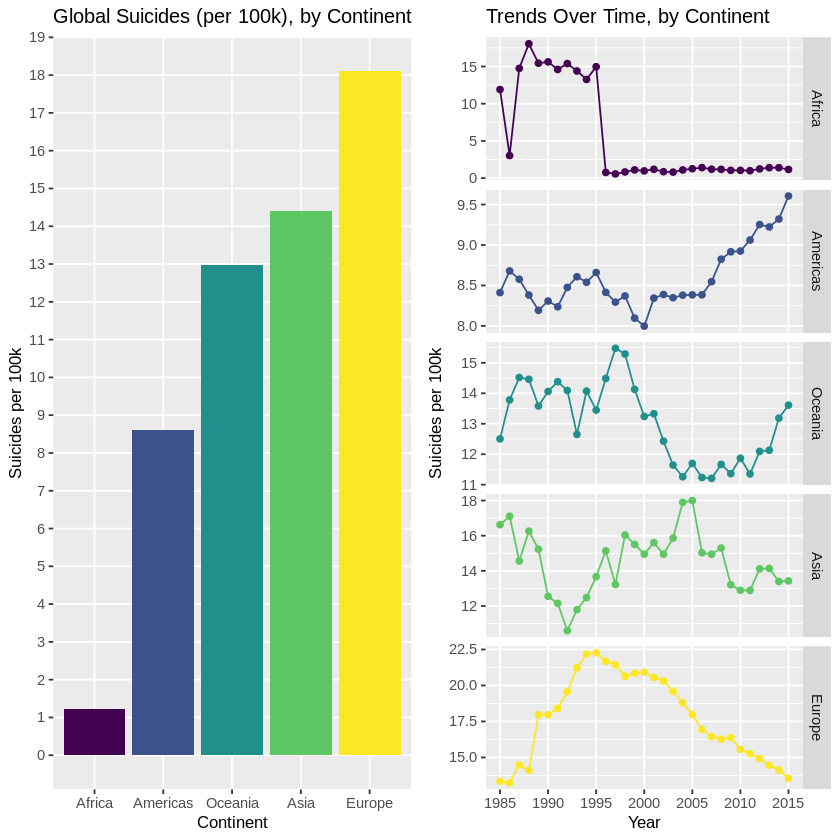

In [13]:
continent <- suicide_data %>%
  group_by(continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  arrange(suicide_per_100k)

continent$continent <- factor(continent$continent, ordered = T, levels = continent$continent)

continent_plot <- ggplot(continent, aes(x = continent, y = suicide_per_100k, fill = continent)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Global Suicides (per 100k), by Continent",
  x = "Continent", 
  y = "Suicides per 100k", 
  fill = "Continent") +
  theme(legend.position = "none", title = element_text(size = 10)) + 
  scale_y_continuous(breaks = seq(0, 20, 1), minor_breaks = F)


continent_time <- suicide_data %>%
  group_by(year, continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)

continent_time$continent <- factor(continent_time$continent, ordered = T, levels = continent$continent)

continent_time_plot <- ggplot(continent_time, aes(x = year, y = suicide_per_100k, col = factor(continent))) + 
  facet_grid(continent ~ ., scales = "free_y") + 
  geom_line() + 
  geom_point() + 
  labs(title = "Trends Over Time, by Continent", 
       x = "Year", 
       y = "Suicides per 100k", 
       color = "Continent") + 
  theme(legend.position = "none", title = element_text(size = 10)) + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F)

grid.arrange(continent_plot, continent_time_plot, ncol = 2)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


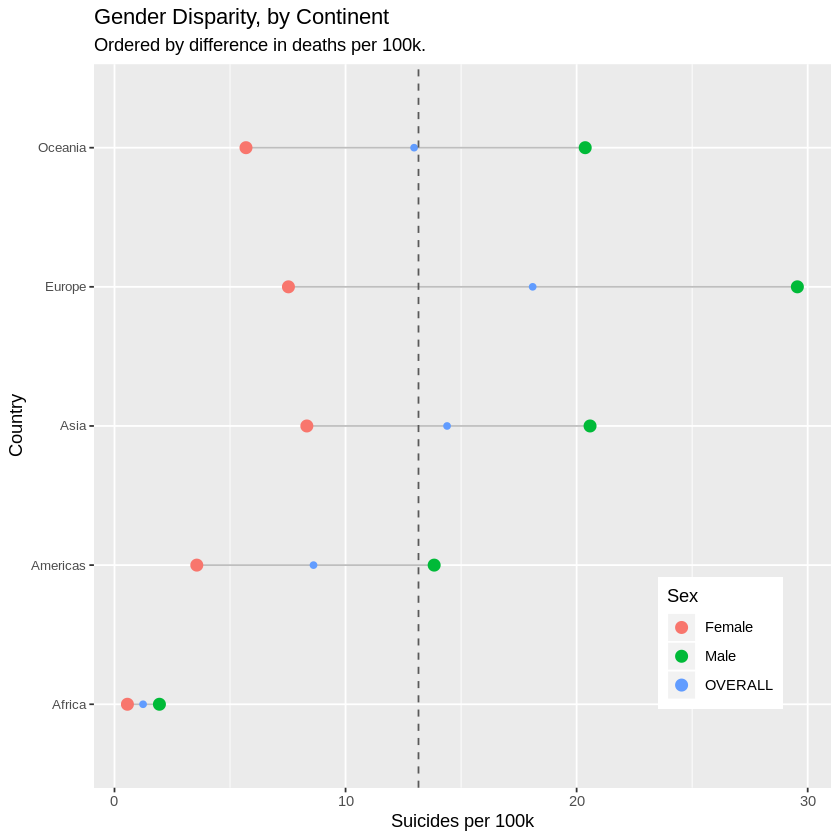

In [14]:
install.packages("ggalt")
library(ggalt)

continent_long <- suicide_data %>%
  group_by(continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  mutate(sex = "OVERALL")

sex_continent_long <- suicide_data %>%
  group_by(continent, sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000)


sex_continent_wide <- sex_continent_long %>%
  pivot_wider(names_from = sex, values_from = suicide_per_100k) %>%
  arrange(Male - Female)


sex_continent_wide$country <- factor(sex_continent_wide$continent, 
                                         ordered = T, 
                                         levels = sex_continent_wide$continent)

sex_continent_long$country <- factor(sex_continent_long$continent, 
                                   ordered = T, 
                                   levels = sex_continent_wide$continent)

plot <- ggplot(sex_continent_wide, aes(y = continent, color = sex)) + 
  geom_dumbbell(aes(x = Female, xend = Male), color = "grey", size = .5) + 
  geom_point(aes(x = suicide_per_100k), size = 3, data = sex_continent_long) + 
  geom_point(aes(x = suicide_per_100k), data = continent_long) + 
  geom_vline(xintercept = global_average, linetype = 2, color = "grey35", size = 0.5) +
  theme(axis.text.y = element_text(size = 8), 
        legend.position = c(0.85, 0.2)) + 
  scale_x_continuous(breaks = seq(0, 80, 10)) +
  labs(title = "Gender Disparity, by Continent", 
       subtitle = "Ordered by difference in deaths per 100k.", 
       x = "Suicides per 100k", 
       y = "Country", 
       color = "Sex")

ggsave("plot.png", plot = plot, width = 12, height = 8)
plot


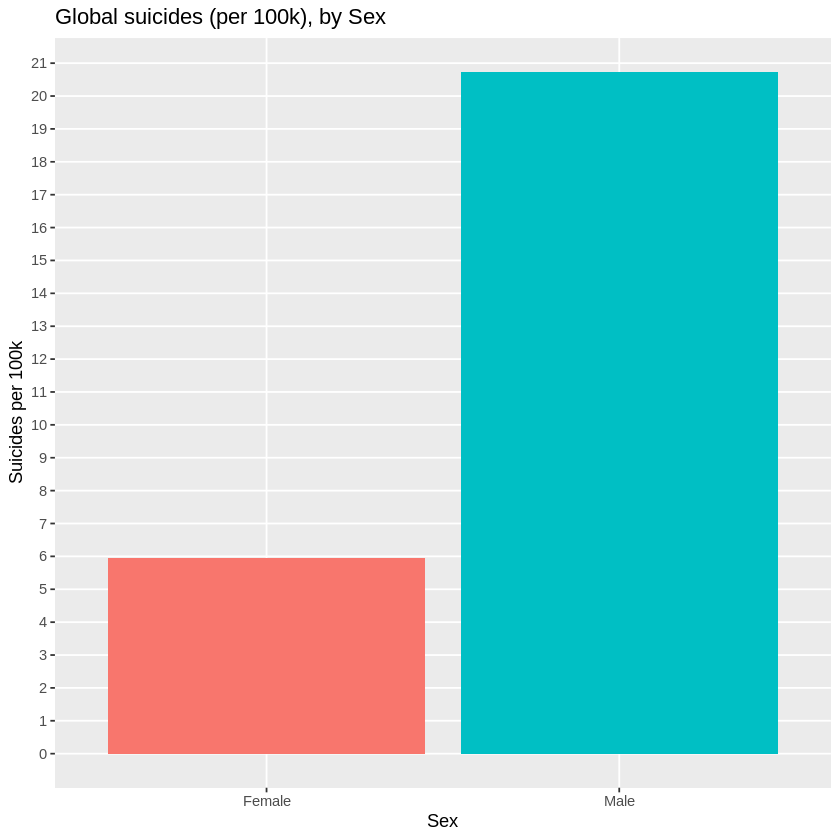

In [15]:
sex_plot <- suicide_data %>%
  group_by(sex) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
ggplot(aes(x = sex, y = suicide_per_100k, fill = sex)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Global suicides (per 100k), by Sex",
       x = "Sex", 
       y = "Suicides per 100k") +
  theme(legend.position = "none") + 
  scale_y_continuous(breaks = seq(0, 25), minor_breaks = F)
sex_plot

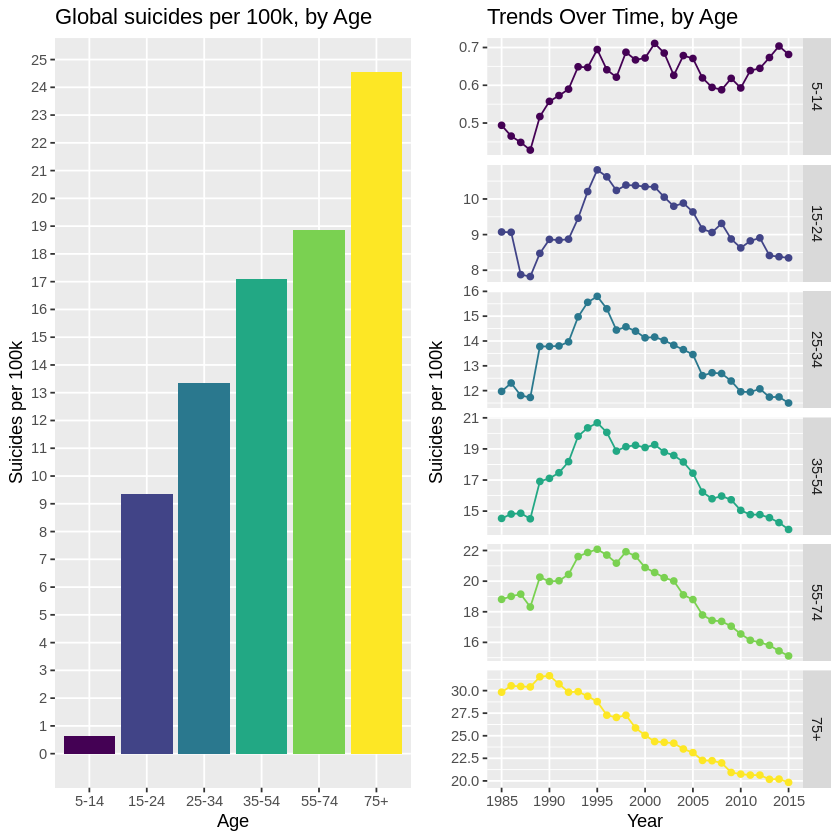

In [16]:
age_plot <- suicide_data %>%
  group_by(age) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = age, y = suicide_per_100k, fill = age)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Global suicides per 100k, by Age",
       x = "Age", 
       y = "Suicides per 100k") +
  theme(legend.position = "none") + 
  scale_y_continuous(breaks = seq(0, 30, 1), minor_breaks = F)

### with time
age_time_plot <- suicide_data %>%
  group_by(year, age) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = year, y = suicide_per_100k, col = age)) + 
  facet_grid(age ~ ., scales = "free_y") + 
  geom_line() + 
  geom_point() + 
  labs(title = "Trends Over Time, by Age", 
       x = "Year", 
       y = "Suicides per 100k", 
       color = "Age") + 
  theme(legend.position = "none") + 
  scale_x_continuous(breaks = seq(1985, 2015, 5), minor_breaks = F)


grid.arrange(age_plot, age_time_plot, ncol = 2)

In [17]:
data1 <- suicide_data %>%
  rename(region = 'continent') %>% as.data.frame()
head(data1)

country,country_code,region,continent_code,year,sex,age,suicides_no,population,gdp_for_year,gdp_per_capita,generation,latitude,longitude
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<ord>,<int>,<int>,<fct>,<int>,<ord>,<dbl>,<dbl>
Albania,ALB,Europe,EUR,1987,Male,15-24,21,312900,"2,156,624,900",796,Generation X,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Male,35-54,16,308000,"2,156,624,900",796,Silent,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Female,15-24,14,289700,"2,156,624,900",796,Generation X,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Male,75+,1,21800,"2,156,624,900",796,G.I. Generation,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Male,25-34,9,274300,"2,156,624,900",796,Boomers,41.15333,20.16833
Albania,ALB,Europe,EUR,1987,Female,75+,1,35600,"2,156,624,900",796,G.I. Generation,41.15333,20.16833


In [18]:
library(plotly)
country_mean_gdp <- suicide_data %>%
  group_by(country, continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no), na.rm = TRUE) / sum(as.numeric(population), na.rm = TRUE)) * 100000, 
            gdp_per_capita = mean(gdp_per_capita, na.rm = TRUE))
head(country_mean_gdp)


Attaching package: ‘plotly’

The following object is masked from ‘package:ggmap’:

    wind

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout



country,continent,suicide_per_100k,gdp_per_capita
<fct>,<fct>,<dbl>,<dbl>
Albania,Europe,3.1608267,1859.045
Antigua and Barbuda,Americas,0.5527005,10448.185
Argentina,Americas,7.9363085,7914.097
Armenia,Asia,2.4523624,1807.458
Aruba,Americas,8.0179284,24221.643
Australia,Oceania,12.9265987,32776.400


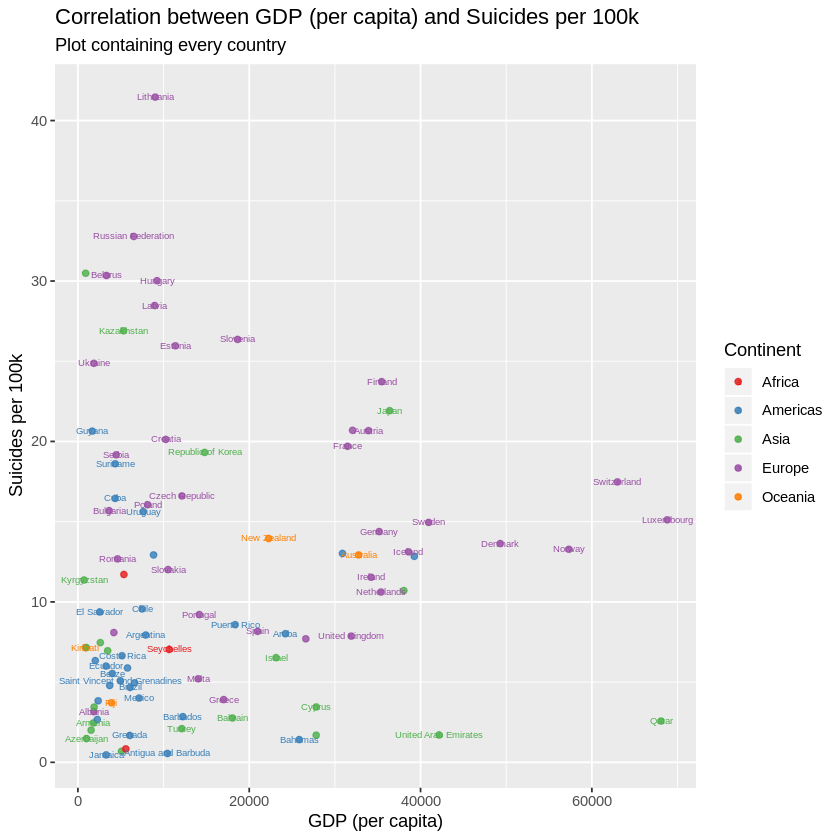

In [19]:
country_mean_gdp <- suicide_data %>%
  group_by(country, continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no), na.rm = TRUE) / sum(as.numeric(population), na.rm = TRUE)) * 100000, 
            gdp_per_capita = mean(gdp_per_capita, na.rm = TRUE))

ggplot(country_mean_gdp, aes(x = gdp_per_capita, y = suicide_per_100k, color = continent)) + 
  geom_point(alpha=0.8) + 
  geom_text(aes(label=country), size=2, check_overlap = TRUE) +
  xlab("GDP (per capita)") + ylab("Suicides per 100k") +
  labs(title = "Correlation between GDP (per capita) and Suicides per 100k", 
       subtitle = "Plot containing every country",
       color = "Continent") +
  scale_color_brewer(palette = "Set1")
